# Controlled-U and Multi-Controlled-U (compact)

We implement the controlled U gate, and use it to further construct multi controlled U gate.

$$CU=(P(\alpha)\otimes I)(I\otimes A)\,CX\,(I\otimes B)\,CX\,(I\otimes C)$$
with $A=R_z(\phi)R_y(\tfrac\theta2)$, $B=R_y(-\tfrac\theta2)R_z(-\tfrac{\phi+\lambda}2)$, $C=R_z(\tfrac{\lambda-\phi}2)$. 

Control : left qubit, Target : right qubit.


In [47]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import UGate, UnitaryGate

# Directly construct CU following the above formula
def CU_from_angles(alpha: float, theta: float, phi: float, lam: float) -> QuantumCircuit:
    """
    Build CU exactly as:
      (P(alpha) ⊗ I) · (I ⊗ A) · CX · (I ⊗ B) · CX · (I ⊗ C)
    with
      A = Rz(phi) · Ry(theta/2)
      B = Ry(-theta/2) · Rz(-(phi+lam)/2)
      C = Rz((lam-phi)/2)
    Control = left qubit (index 1), Target = right qubit (index 0).
    """
    qc = QuantumCircuit(2, name="CU_exact")
    control, target = 1, 0
    qc.rz((lam - phi)/2, target)
    qc.cx(control, target)
    qc.rz(-(phi + lam)/2, target)
    qc.ry(-theta/2, target)
    qc.cx(control, target)
    qc.ry(theta/2, target)
    qc.rz(phi, target)
    qc.p(alpha, control)
    return qc


In [48]:
from qiskit import QuantumRegister, AncillaRegister

# recursively build an AND ladder of n controls using n-1 ancillas
def _and_ladder(qc: QuantumCircuit, ctrls, work):
    n = len(ctrls)
    if n == 1: return ctrls[0]
    qc.ccx(ctrls[0], ctrls[1], work[0])
    for k in range(2, n):
        qc.ccx(ctrls[k], work[k-2], work[k-1])
    return work[n-2]

# recursively uncompute the AND ladder
def _uncompute_and_ladder(qc: QuantumCircuit, ctrls, work):
    n = len(ctrls)
    if n <= 1: return
    for k in range(n-1, 1, -1):
        qc.ccx(ctrls[k], work[k-2], work[k-1])
    qc.ccx(ctrls[0], ctrls[1], work[0])

# Build C^nU from CU and AND ladder
def CnU_from_angles(n: int, alpha: float, theta: float, phi: float, lam: float,
                    controls_left: bool = True, name="C^nU"):
    if n < 1: raise ValueError("n must be >= 1")
    q = QuantumRegister(n+1, "q")
    if n >= 2:
        a = AncillaRegister(n-1, "a")
        qc = QuantumCircuit(q, a, name=name)
        work = list(a)
    else:
        qc = QuantumCircuit(q, name=name); work = []
    target = q[0]; ctrls = list(q[1:]) if controls_left else (q[n], list(q[:n]))[1]
    if not controls_left:
        target = q[n]; ctrls = list(q[:n])
    flag = _and_ladder(qc, ctrls, work) if n >= 2 else ctrls[0]
    qc.append(CU_from_angles(alpha, theta, phi, lam).to_gate(label="CU"), [target, flag])
    if n >= 2: _uncompute_and_ladder(qc, ctrls, work)
    return qc


## Sanity checks

00 -> {np.str_('00'): np.complex128(1+1.0146536357569526e-17j)}
01 -> {np.str_('01'): np.complex128(1-1.0146536357569525e-17j)}
10 -> {np.str_('11'): np.complex128(1.9967346175427393e-16-1j)}
11 -> {np.str_('10'): np.complex128(-1.996734617542739e-16-1j)}


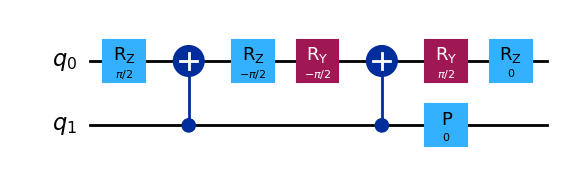

In [49]:
from qiskit.quantum_info import Operator, Statevector

# Basis action for U=X (θ=π, φ=0, λ=π), α=0
qc_X = CU_from_angles(0.0, np.pi, 0.0, np.pi)
for lab in ["00","01","10","11"]:
    print(lab, "->", Statevector.from_label(lab).evolve(qc_X).to_dict(decimals=3))

# We can check that the action on computational basis concides with that of CX.

qc_X.draw("mpl")

## Demo and Verification
For a certain input unitary, we compare the given input matrix and the last 2*2 block matrix of the constructed CnU matrix.

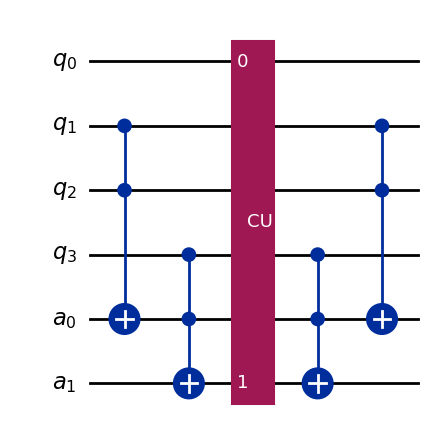

In [50]:
# Draw an example C^3U
alpha_demo = 0.2
theta_demo = 1.1
phi_demo   = 0.4
lam_demo   = -0.7

qc3 = CnU_from_angles(3, alpha_demo, theta_demo, phi_demo, lam_demo)
qc3.draw("mpl")

In [51]:
U_full = Operator(qc3).data
U_block = U_full[-2:, -2:]
U_goal = np.exp(1j * alpha_demo) * Operator(UGate(theta_demo, phi_demo, lam_demo)).data

W = U_block @ U_goal.conj().T
evals, _ = np.linalg.eig(W)

# Rounding for readability
np.set_printoptions(precision=3, suppress=True)

print("Bottom-right 2x2 block (U_block):")
print(np.round(U_block, 3))
print("\nTarget e^{iα}U(θ,φ,λ):")
print(np.round(U_goal, 3))
print("\nW = U_block U_goal^†:")
print(np.round(W, 3))
print("Eigenvalues of W:", np.round(evals, 3))

# Optional check for equality up to global phase
gamma = np.angle(evals[0])
U_block_unphased = np.exp(-1j * gamma) * U_block
print("\nEqual after removing global phase?",
      np.allclose(U_block_unphased, U_goal, atol=1e-12))

Bottom-right 2x2 block (U_block):
[[ 0.801+0.292j -0.491+0.179j]
 [ 0.382+0.356j  0.851+0.043j]]

Target e^{iα}U(θ,φ,λ):
[[ 0.836+0.169j -0.459+0.251j]
 [ 0.431+0.295j  0.848-0.085j]]

W = U_block U_goal^†:
[[0.989+0.149j 0.   -0.j   ]
 [0.   +0.j    0.989+0.149j]]
Eigenvalues of W: [0.989+0.149j 0.989+0.149j]

Equal after removing global phase? True
